In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
import matplotlib.pyplot as plt



import os
import argparse

In [ ]:

class Block(nn.Module):
    '''Grouped convolution block.'''
    expansion = 2

    def __init__(self, in_planes, cardinality=32, bottleneck_width=4, stride=1):
        super(Block, self).__init__()
        group_width = cardinality * bottleneck_width
        self.conv1 = nn.Conv2d(in_planes, group_width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(group_width)
        self.conv2 = nn.Conv2d(group_width, group_width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(group_width)
        self.conv3 = nn.Conv2d(group_width, self.expansion*group_width, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*group_width)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*group_width:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*group_width, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*group_width)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNeXt(nn.Module):
    def __init__(self, num_blocks, cardinality, bottleneck_width, num_classes=10):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(num_blocks[0], 1)
        self.layer2 = self._make_layer(num_blocks[1], 2)
        self.layer3 = self._make_layer(num_blocks[2], 2)
        # self.layer4 = self._make_layer(num_blocks[3], 2)
        self.linear = nn.Linear(cardinality*bottleneck_width*8, num_classes)

    def _make_layer(self, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_planes, self.cardinality, self.bottleneck_width, stride))
            self.in_planes = Block.expansion * self.cardinality * self.bottleneck_width
        # Increase bottleneck_width by 2 after each stage.
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def MyResNeXt():
    return ResNeXt(num_blocks=[3,3,3], cardinality=32, bottleneck_width=4)


In [ ]:


model = MyResNeXt()
sum = 0
for p in model.parameters():
    sum += p.numel()
print(sum)



4761770


In [ ]:
learning_rate = 0.001
batch_size = 128
epochs = 100
weight_decay = 0.0001
#best_acc = 0


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Define your data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define your optimizer and loss function
device = 'cuda' if torch.cuda.is_available else 'cpu'
device
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [ ]:
train_losses = []
train_accs = []

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        _, pred = output.max(1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
        
        
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_acc = 100. * correct / total
    train_accs.append(train_acc)
    print('Train Epoch: {} Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        epoch, train_loss, correct, total, train_acc))


In [ ]:

best_acc = 0.0
test_losses = []
test_accs = []

def test(model, device, test_loader, criterion):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() 
            _, pred = output.max(1)
            correct += pred.eq(target).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc = correct / len(test_loader.dataset)
    test_accs.append(test_acc)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
        # Save checkpoint.
    acc = 100.*correct/len(test_loader.dataset)
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint_sgd'):
            os.mkdir('checkpoint_sgd')
        torch.save(state, './checkpoint_sgd/ckpt.pth')
        best_acc = acc


In [ ]:


for epoch in range(epochs):
    train(model, device, train_loader, optimizer, criterion, epoch)
    test(model, device, test_loader, criterion)
    scheduler.step()
    
# Plot the loss and accuracy graphs for the train and test data
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title('Training Loss')
axs[0, 1].plot(train_accs)
axs[0, 1].set_title('Training Accuracy')
axs[1, 0].plot(test_losses)
axs[1, 0].set_title('Test Loss')
axs[1, 1].plot(test_accs)
axs[1, 1].set_title('Test Accuracy')
plt.show()



Train Epoch: 0 Average Loss: 1.4273, Accuracy: 23785/50000 (48%)

Test set: Average loss: 0.0207, Accuracy: 5237/10000 (52%)

Saving..
Train Epoch: 1 Average Loss: 1.2437, Accuracy: 27437/50000 (55%)

Test set: Average loss: 0.0185, Accuracy: 5784/10000 (58%)

Saving..
Train Epoch: 2 Average Loss: 1.1064, Accuracy: 30155/50000 (60%)

Test set: Average loss: 0.0166, Accuracy: 6247/10000 (62%)

Saving..
Train Epoch: 3 Average Loss: 0.9954, Accuracy: 32203/50000 (64%)

Test set: Average loss: 0.0154, Accuracy: 6575/10000 (66%)

Saving..
Train Epoch: 4 Average Loss: 0.9128, Accuracy: 33815/50000 (68%)

Test set: Average loss: 0.0146, Accuracy: 6752/10000 (68%)

Saving..
Train Epoch: 5 Average Loss: 0.8455, Accuracy: 35070/50000 (70%)

Test set: Average loss: 0.0134, Accuracy: 7002/10000 (70%)

Saving..
Train Epoch: 6 Average Loss: 0.7865, Accuracy: 36033/50000 (72%)

Test set: Average loss: 0.0132, Accuracy: 7076/10000 (71%)

Saving..
Train Epoch: 7 Average Loss: 0.7333, Accuracy: 37017/50

KeyboardInterrupt: 

/home/pd2365/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/pd2365/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


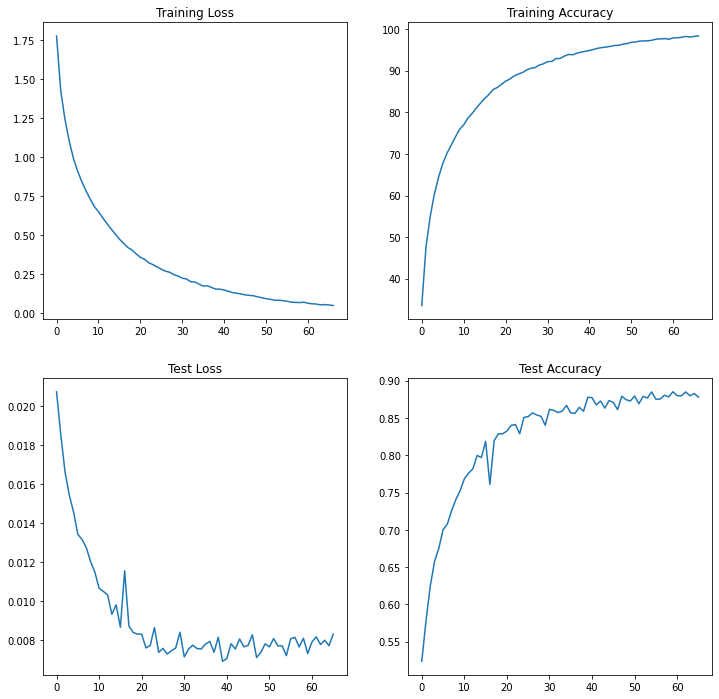

In [ ]:
# Plot the loss and accuracy graphs for the train and test data
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title('Training Loss')
axs[0, 1].plot(train_accs)
axs[0, 1].set_title('Training Accuracy')
axs[1, 0].plot(test_losses)
axs[1, 0].set_title('Test Loss')
axs[1, 1].plot(test_accs)
axs[1, 1].set_title('Test Accuracy')
plt.show()


In [ ]:
fig.savefig('my_plot.png')